<h1> 1. Exploring natality dataset </h1>

This notebook illustrates:
<ol>
<li> Exploring a BigQuery dataset using Datalab
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'asl-ml-immersion-temp'
PROJECT = 'asl-ml-immersion'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

Creating gs://asl-ml-immersion-temp/...


<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [16]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_race,
  plurality,
  gestation_weeks,
  mother_married,
  ever_born,
  cigarette_use,
  alcohol_use,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [17]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,ever_born,cigarette_use,alcohol_use,hashmonth
0,4.916308,False,34,2,1,27.0,False,10,None,False,6691862025345277042
1,5.985550,False,33,1,1,34.0,True,2,None,False,1403073183891835564
2,5.187477,False,20,1,1,35.0,False,2,None,False,1088037545023002395
3,5.061814,False,32,2,1,35.0,True,4,None,False,7108882242435606404
4,5.313141,False,27,1,1,35.0,True,3,None,False,4979697502521811334


Let's write a query to find the unique values for each of the columns and the count of those values.
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [6]:
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bq.Query(sql).execute().result().to_dataframe()

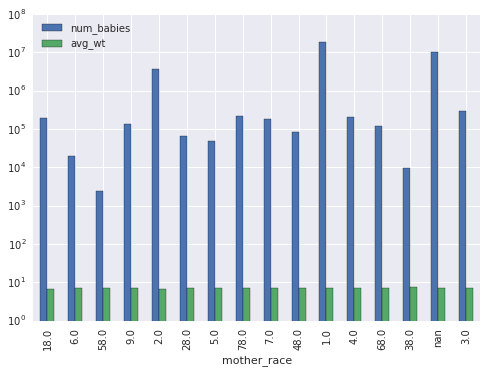

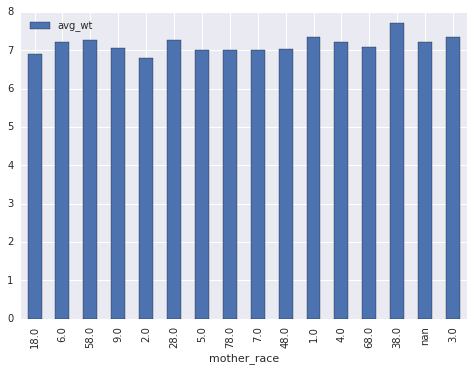

In [7]:
df = get_distinct_values('mother_race')
df.plot(x='mother_race', logy='num_babies', kind='bar');
df.plot(x='mother_race', y='avg_wt', kind='bar');

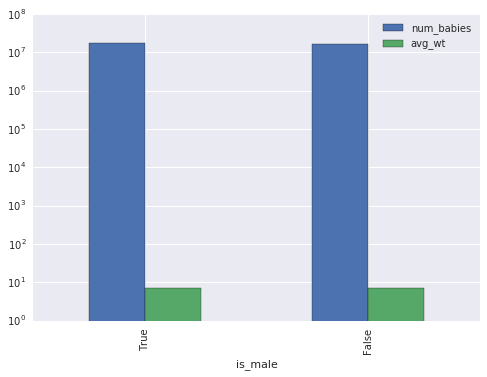

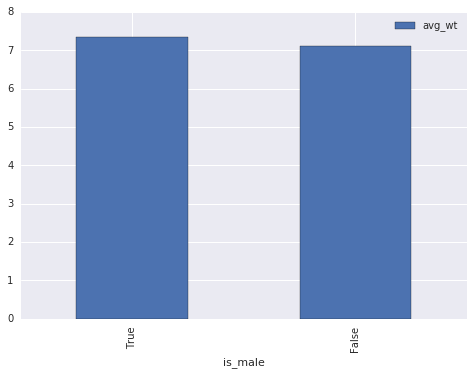

In [8]:
df = get_distinct_values('is_male')
df.plot(x='is_male', logy='num_babies', kind='bar');
df.plot(x='is_male', y='avg_wt', kind='bar');

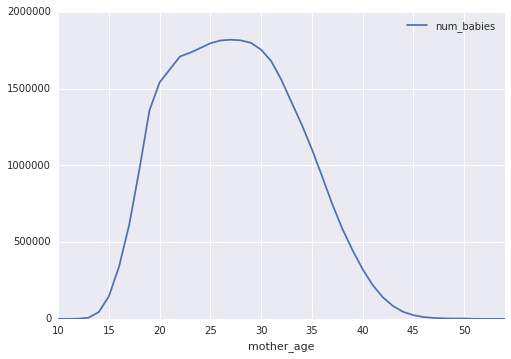

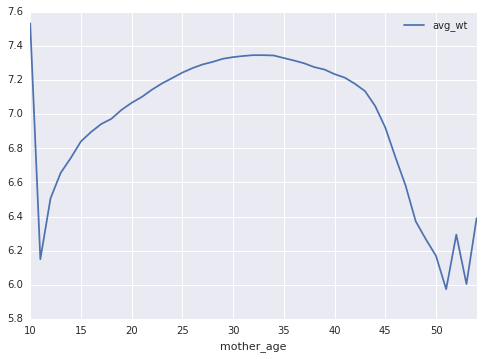

In [9]:
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies');
df.plot(x='mother_age', y='avg_wt');

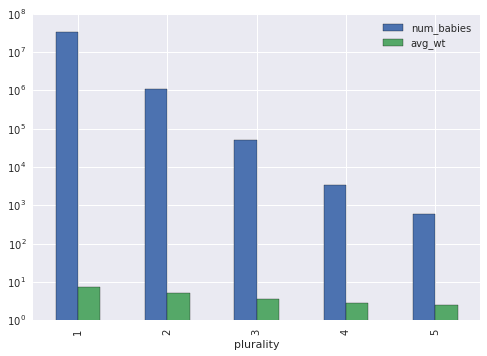

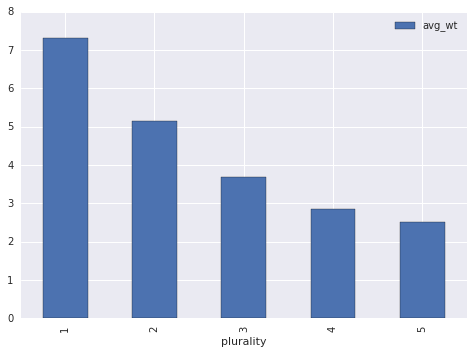

In [10]:
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', logy='num_babies', kind='bar');
df.plot(x='plurality', y='avg_wt', kind='bar');

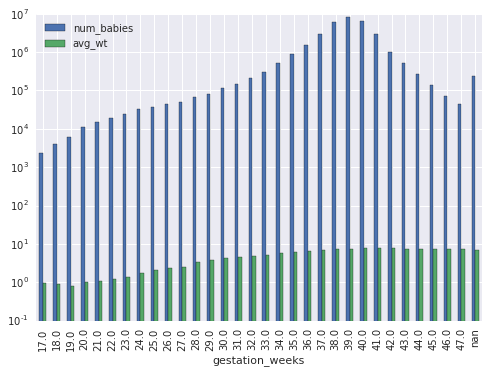

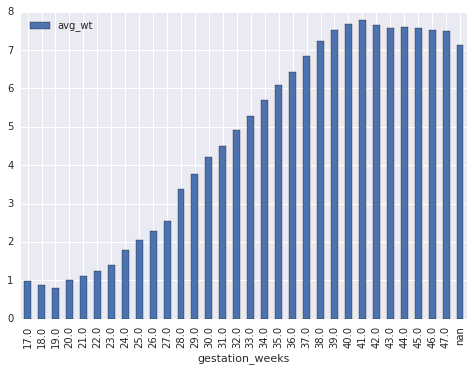

In [11]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', logy='num_babies', kind='bar');
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

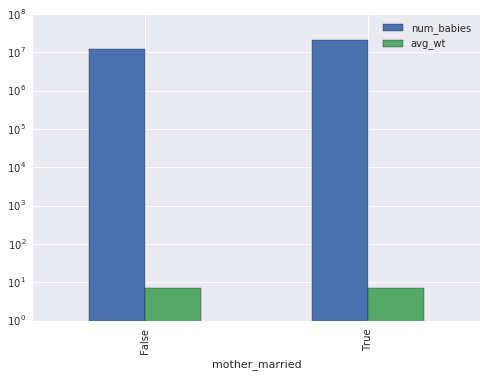

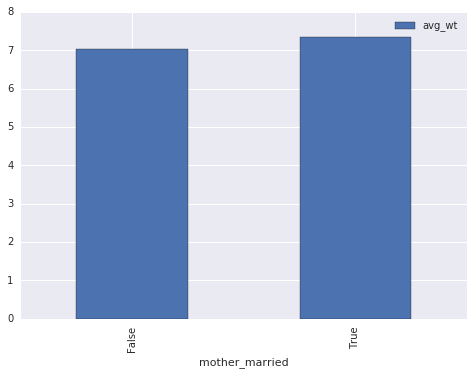

In [12]:
df = get_distinct_values('mother_married')
df.plot(x='mother_married', logy='num_babies', kind='bar');
df.plot(x='mother_married', y='avg_wt', kind='bar');

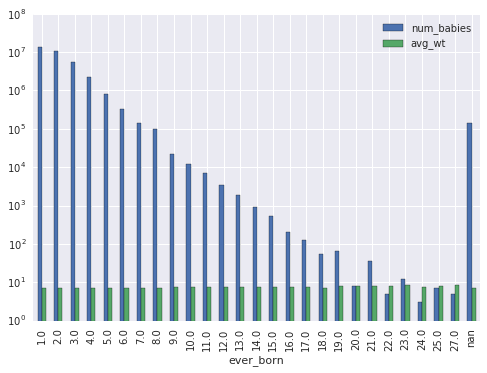

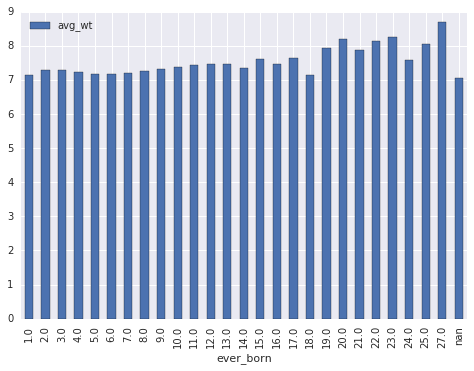

In [13]:
df = get_distinct_values('ever_born')
df = df.sort_values('ever_born')
df.plot(x='ever_born', logy='num_babies', kind='bar');
df.plot(x='ever_born', y='avg_wt', kind='bar');

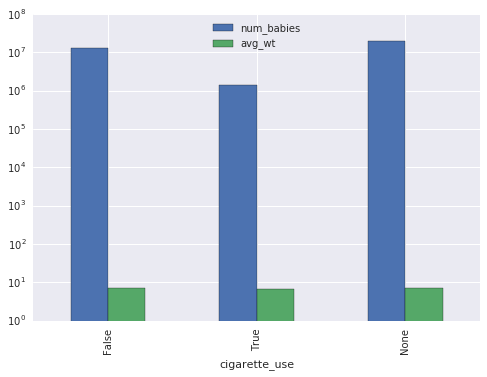

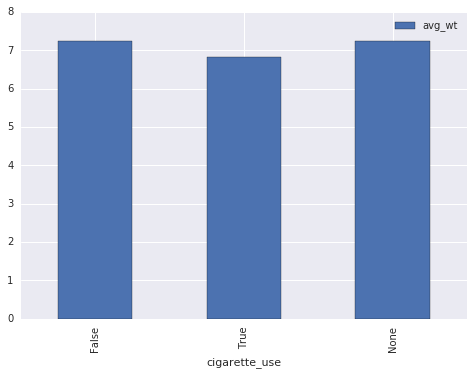

In [14]:
df = get_distinct_values('cigarette_use')
df.plot(x='cigarette_use', logy='num_babies', kind='bar');
df.plot(x='cigarette_use', y='avg_wt', kind='bar');

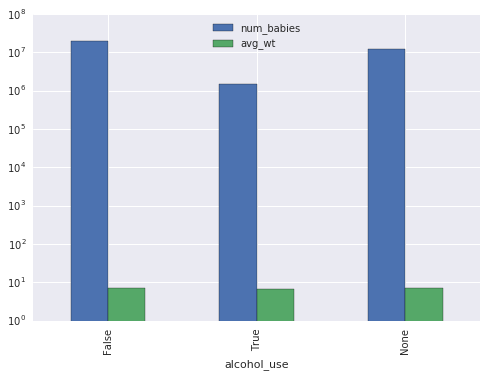

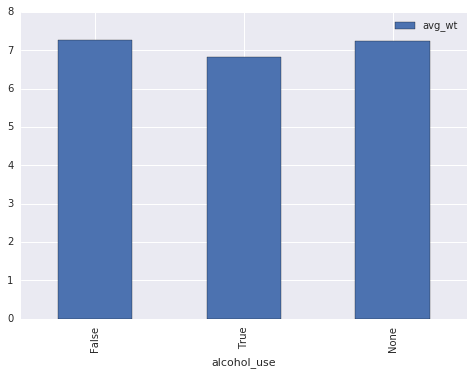

In [15]:
df = get_distinct_values('alcohol_use')
df.plot(x='alcohol_use', logy='num_babies', kind='bar');
df.plot(x='alcohol_use', y='avg_wt', kind='bar');

Other than the ever_born (the total number of babies born to this mother), the factors all seem to play a part in the baby's weight.  Male babies are heavier on average than female babies. The mother's age and race play a part (age much more than race -- teenage and middle-aged moms tend to have lower-weight babies).  Twins, triplets, etc. are lower weight than single births.  Preemies weigh in lower as do babies born to single moms. Moms who use alcohol or cigarettes have babies that weigh lower on average.
<p>
In the next notebook, I will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License